# Example of de novo alignment of multiple slices

Author: Yu Bai, edited by Peter Lais on 11/11/2023

In [1]:
# Preparation: make relevant imports, set seed, confirm GPU recognized.
import os
import skimage
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import tensorflow as tf
import scanpy as sc
import sys
import anndata as ad
import pickle

sys.path.append('../code/')
from libs.utils import simple_efm_kwargs_generator
from libs.models import STaCkerSemiSupervised
from libs.alignment import stacker_register
from libs.utils.image.transcriptome import createCompositeImg
from libs.utils.auxiliary import *

seed = 0
rng = np.random.default_rng(seed)

num_gpus = len(tf.config.list_physical_devices("GPU"))
gpus_color = '\033[0;32m' if num_gpus > 0 else '\033[0;31m'
gpus_string = f"{gpus_color}{num_gpus}\033[0m"
print(f'Recognized GPUs: {gpus_string}')

Recognized GPUs: 1


2023-11-11 06:02:45.167723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:977] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-11 06:02:45.168583: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:977] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-11 06:02:45.169051: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:977] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# load unaligned slices
PIK='example2_input.obj' 
with open(PIK, "rb") as f:
    [miniext]=pickle.load(f)

/tmp/ipykernel_3401/2980544594.py:4: DeprecationWarning:

Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.



In [3]:
# preparation data: scale, crop/pad the slices to similar size and orientation 
rescaled=scaleAdata(miniext, ratio=0.07, finalhires=512, coarse=0)

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1840: UserWarning:

Variable names are not unique. To make them unique, call `.var_names_make_unique`.

 bad det -1 v 1 u -1
 bad det -1 v 1 u -1 new 1


rangeX=410.2544811790052
[405.6095428466797, 415.06912554366755, 401.9854241417966, 414.89941951133073]
[410.2430294308542, 405.3277240341396, 406.23199212636774, 410.26567651482367]
rangeY=363.1310404805628
[355.03031635284424, 371.8798970531463, 359.32566311482924, 366.9364178462963]
[359.0845823735386, 363.1545665077611, 363.12045015051854, 362.8396367602921]
[54.038007729697604, 51.76969712475024]
[113.10771865205538, 115.52748845718176, 115.08232372199045, 113.09656965407042]
[138.29265742497282, 136.28903325099623, 136.305828490448, 136.4440709205113]


In [4]:
# For each slice, construct composite image using the tissue image and the contour map based on transcriptomic clusters
clust_file='example2_spots.csv'
for each in range(len(rescaled)):
    rescaled[each]=createCompositeImg(rescaled[each],clust_file=clust_file,res="hires",maskval=0,med_filter_size=4,trimMax=2)

In [5]:
# Create the STaCKer model, load the appropriate weights, and then get the predictor component
model_sm = STaCkerSemiSupervised(img_shape=(256,256,3),
                                    lbl_shape=(256,256,3),
                                    auxiliary_outputs=['def_output', 'inv_def_output'],
                                    efm_kwargs=simple_efm_kwargs_generator(dict_inputs=True,
                                                                           dict_outputs=True,
                                                                           output_names_list=['moved_img',
                                                                                              'def_output',
                                                                                              'inv_def_output',
                                                                                              'moved_lbl']))
model_sm.load_weights('../data/stacker-params-sample/checkpoints/variables/variables')
model_sm = model_sm.references.base_model

model_sm.get_input_signature()

2023-11-11 06:05:54.166547: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-11 06:05:54.169016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:977] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-11 06:05:54.169792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:977] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-11 06:05:54.170412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:977] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have be

{'sm_semi_base_moving_img': TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='sm_semi_base_moving_img'),
 'sm_semi_base_fixed_img': TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='sm_semi_base_fixed_img')}

In [6]:
# Register the images.
rs = stacker_register(slices=rescaled,
                     alignment_mode='templateless',
                     spatial_strategy='points',
                     spatial_target='hires',
                     max_reg_dim=512,
                     mode='dense',
                     model=model_sm,
                     dense_moving_img_name='sm_semi_base_moving_img',
                     dense_fixed_img_name='sm_semi_base_fixed_img',
                     dense_deff_name='def_output',
                     dense_inv_deff_name='inv_def_output',
                     search_factor=5)


2023-11-11 06:06:18.874439: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


----- unaligned --------


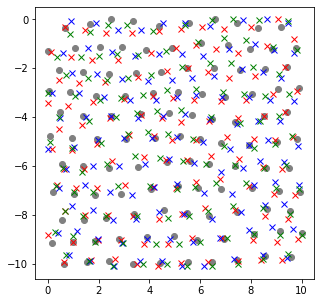

In [7]:
# Display unaligned results.
print("----- unaligned --------")
coord1=scale_spatial_coords2(rescaled[0].obsm['spatial'])
coord2=scale_spatial_coords2(rescaled[1].obsm['spatial'],ref_min=rescaled[0].obsm['spatial'].min(0),
                             ref_max=(rescaled[0].obsm['spatial']-rescaled[0].obsm['spatial'].min(0)).max(0))
coord3=scale_spatial_coords2(rescaled[2].obsm['spatial'],ref_min=rescaled[0].obsm['spatial'].min(0),
                             ref_max=(rescaled[0].obsm['spatial']-rescaled[0].obsm['spatial'].min(0)).max(0))
coord4=scale_spatial_coords2(rescaled[3].obsm['spatial'],ref_min=rescaled[0].obsm['spatial'].min(0),
                             ref_max=(rescaled[0].obsm['spatial']-rescaled[0].obsm['spatial'].min(0)).max(0))
plt.figure(figsize=(5,5))
plt.plot(coord1[:,0], -coord1[:,1], 'o', color='grey');
plt.plot(coord2[:,0], -coord2[:,1], 'x', color='red');
plt.plot(coord3[:,0], -coord3[:,1], 'x', color='blue');
plt.plot(coord4[:,0], -coord4[:,1], 'x', color='green');

----- templateless --------


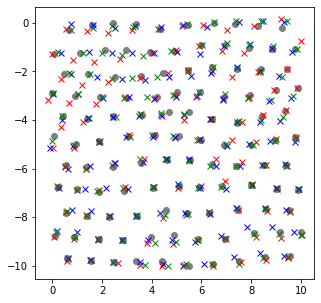

In [8]:
# Show aligned results.
templateless_spatial=[each.obsm['spatial'] for each in rs]

print("----- templateless --------")
plt.figure(figsize=(5,5))
coord1=scale_spatial_coords2(templateless_spatial[0])
coord2=scale_spatial_coords2(templateless_spatial[1],ref_min=templateless_spatial[0].min(0),
                             ref_max=(templateless_spatial[0]-templateless_spatial[0].min(0)).max(0))
coord3=scale_spatial_coords2(templateless_spatial[2],ref_min=templateless_spatial[0].min(0),
                             ref_max=(templateless_spatial[0]-templateless_spatial[0].min(0)).max(0))
coord4=scale_spatial_coords2(templateless_spatial[3],ref_min=templateless_spatial[0].min(0),
                             ref_max=(templateless_spatial[0]-templateless_spatial[0].min(0)).max(0))
plt.plot(coord1[:,0], -coord1[:,1], 'o', color='grey');
plt.plot(coord2[:,0], -coord2[:,1], 'x', color='red');
plt.plot(coord3[:,0], -coord3[:,1], 'x', color='blue');
plt.plot(coord4[:,0], -coord4[:,1], 'x', color='green');